# Cloning Quasars

- Upsample this distribution in two ways, using both rejection sampling and inverse transform.
- Check, at least visually, that the two cloned distribitions are indeed similar to the observed one (**for a quantitative check, come back to this point in a few lectures**)

In [51]:
from astroML.datasets import fetch_dr7_quasar
import matplotlib.pyplot as plt
import numpy as np
import scipy

#TODO: KS Test
#TODO: converge result for rejection sampling on N

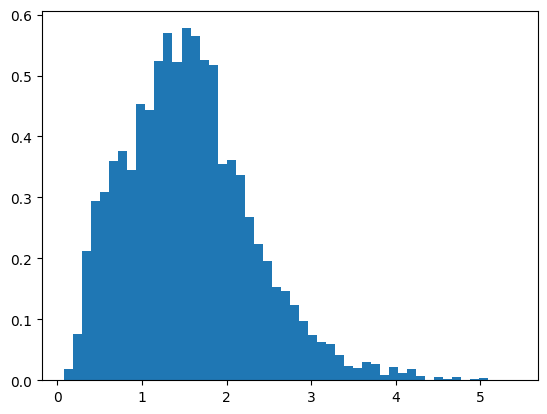

In [81]:
# Fetch the quasar data
data = fetch_dr7_quasar()

# select the first 10000 points
data = data[:10000]

z = data['redshift']

plt.hist(z, density=True, bins = 50); #; not to show counts and bins values

## Rejection Sampling

10000
288373


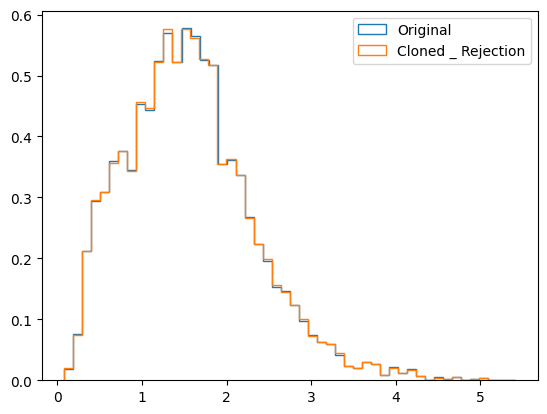

In [53]:
#N of sampling : not total, as limited by condition of rejection
N = 1000000

def rejection(N):
    # Original Distribution
    # As the original distribution is not known a priori, the pdf can be retrieved directly by the histogram
    counts, bins = np.histogram(z, bins=50, density=True)
    disth = scipy.stats.rv_histogram((counts,bins))

    #Rejection Sampling
    # Proposal distribution q(x) : Uniform
    # Random sample of x
    x=np.random.uniform(0,6,N)

    # Uniform Distribution u between 0 and max of original distribution
    # Random sample of y
    y=np.random.uniform(0,counts.max(),N)

    #Rejection Conditon
    new_sample = x[y<disth.pdf(x)]

    return new_sample

new_sample = rejection(N)
print(len(z))
print(len(new_sample)) 

    #Check the result
plt.hist(z, density=True, bins = 50, histtype='step', label='Original') 
plt.hist(new_sample, density=True, bins = 50, histtype='step', label='Cloned _ Rejection') 
plt.legend()

## Inverse Transform

10000
288373
1000000


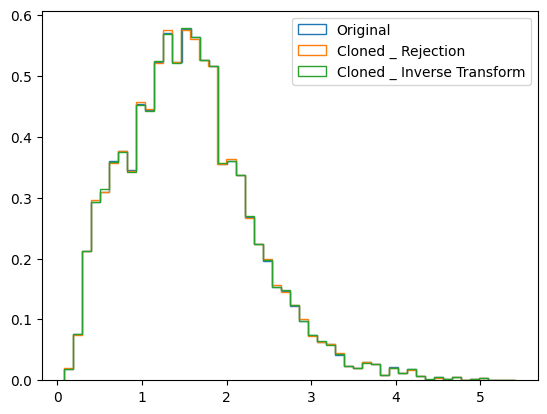

In [54]:
N_inverse = 1000000

def inverse_transform(N):
    # Step 1
    # Comulative Density Function
    z.sort() 
    cdf_y = np.linspace(0,1,len(z)) 
    cdf_x = z
    #plt.plot(cdf_x, cdf_y, label = 'CDF')

    # Quantile Function - Inverse CDF
    quantile = scipy.interpolate.interp1d(cdf_y, cdf_x)

    # Step 2
    # Generate Sample from Uniform Distribution [0,1]
    u = np.random.uniform(0,1,N)

    # Step 3
    # Using the quantile function, values of x below which the distribution is contained
    new_sample_it = quantile(u)
    return new_sample_it

new_sample_it = inverse_transform(N)
#_____
print(len(z))
print(len(new_sample)) 
print(len(new_sample_it)) 

#Check the result
plt.hist(z, density=True, bins = 50, histtype='step', label='Original') #TODO: astropy binning
plt.hist(new_sample, density=True, bins = 50, histtype='step', label='Cloned _ Rejection') #TODO: astropy binning
plt.hist(new_sample_it, density=True, bins = 50, histtype='step', label='Cloned _ Inverse Transform') #TODO: astropy binning
plt.legend()



## KS tests

In [55]:
from scipy import stats
_, pvalue = stats.kstest(z, new_sample)
print('Rejection Sampling (D p-value): {} {}'.format(_,pvalue))

_, pvalue_it = stats.kstest(z, new_sample_it)
print('Inverse transform (D p-value): {} {}'.format(_,pvalue_it))

Rejection Sampling (D p-value): 0.00490836763497271 0.9731475735522533
Inverse transform (D p-value): 0.0006029999999999647 1.0


The hypothesis is that the samples are drawn from the same distribution. Choosing a confidence level of 95%, the hypothesis is rejected if the p-value is smaller than 0.05.

As both samples have p-values higher than 0.05, the hypothesis is not rejected. As a result, both the Rejection Sampling and the Inverse Transform rapresent adequately the distribution of data.

However, the Inverse Transform has a p-value higher in respect to the Rejection Sampling. In the following, I investigate if that's related to the number of points of the updated sample in the rejection sampling is lower because of its computation (rejection).

In [56]:
N = np.array([1e3, 1e4, 1e5, 1e6, 1e7], dtype = int)

p_values_rej = []
len_sample_rej = []
loss_rej = []

for n in N:
    new_sample = rejection(n)
    len_sample_rej.append(len(new_sample))
    loss_rej.append(n- len(new_sample))
    _, pvalue = stats.kstest(z, new_sample)
    p_values_rej.append(pvalue)



In [57]:
p_values_it = []
len_sample_it = []
loss_it = []

for n in N:
    new_sample = inverse_transform(n)
    len_sample_it.append(len(new_sample))
    loss_it.append(n - len(new_sample))
    _, pvalue = stats.kstest(z, new_sample)
    p_values_it.append(pvalue)

Text(0, 0.5, 'p-values')

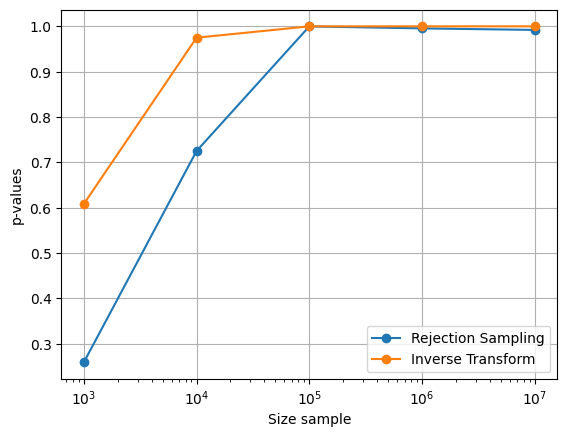

In [60]:
plt.plot(N, p_values_rej, label='Rejection Sampling', marker= 'o')
plt.plot(N, p_values_it, label='Inverse Transform', marker= 'o')
plt.xscale('log')
plt.grid()
plt.legend()
plt.xlabel('Size sample')
plt.ylabel('p-values')

Generally, for low final upsamples the inverse trasform rapresents better the initial distribution. At higher final upsample size, both methods tend to represent the initial distribution optimally having a p-value tending to 1.

---------------

- Think about the cosmology of quasars. How do you think they are distributed? Overplot the theorethical distribution to the measured SDSS data 

Assuming Quasars being distributed uniformely in a comoving volume:

Text(0.5, 0, 'z')

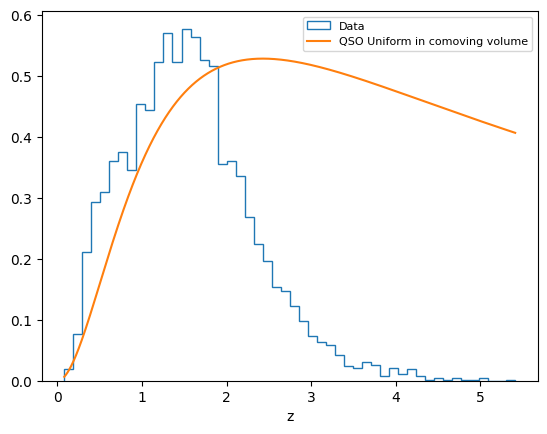

In [80]:
import astropy
from scipy.integrate import quad

#data
plt.hist(z, density=True, bins = 50, histtype='step', label='Data') 

#theoretical pdf of qso in comoving volume
x = np.linspace(np.min(z), np.max(z), 10000)
theoretical_pdf = astropy.cosmology.Planck15.differential_comoving_volume(x).value

#normalization 
norm = 8e10
plt.plot(x, theoretical_pdf/norm, label = 'QSO Uniform in comoving volume')
plt.legend(loc='upper right', prop={'size': 8})
plt.xlabel('z')

According to the theoretical pdf that assumes an uniform distribution of quasars in a comoving volume, at high redshifts the number of quasars observed should be higher. The discrepancy could be lead to the astronomical instrumentation limits to record data at such redshifts.